In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
X = df.loc[:, 2:].values

In [6]:
y = df.loc[:, 1].values

In [7]:
le = LabelEncoder()

In [8]:
y = le.fit_transform(y)

In [12]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

# Pipeline

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [16]:
pipe_lr = make_pipeline(StandardScaler(),
                       PCA(n_components=2),
                       LogisticRegression(random_state=1, solver='lbfgs'))

In [17]:
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=1))])

In [18]:
y_pred = pipe_lr.predict(X_test)

In [20]:
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956


# K-fold cross validation

In [25]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [22]:
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

In [26]:
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold %2d, Class dist.: %s, Acc %3f'%(k+1, np.bincount(y_train[train]), score))

Fold  1, Class dist.: [256 153], Acc 0.934783
Fold  2, Class dist.: [256 153], Acc 0.956522
Fold  3, Class dist.: [256 153], Acc 0.956522
Fold  4, Class dist.: [256 153], Acc 0.934783
Fold  5, Class dist.: [257 153], Acc 0.955556
Fold  6, Class dist.: [257 153], Acc 0.977778
Fold  7, Class dist.: [257 153], Acc 0.933333
Fold  8, Class dist.: [257 153], Acc 0.955556
Fold  9, Class dist.: [257 153], Acc 0.955556


In [28]:
scores

[0.9347826086956522,
 0.9565217391304348,
 0.9565217391304348,
 0.9347826086956522,
 0.9555555555555556,
 0.9777777777777777,
 0.9333333333333333,
 0.9555555555555556,
 0.9555555555555556]

In [29]:
from sklearn.model_selection import cross_val_score

In [30]:
scores = cross_val_score(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=1)

In [31]:
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.014


# Learning Curve

In [32]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [35]:
pipe_lr = make_pipeline(StandardScaler(),
                       LogisticRegression(penalty='l2',
                                         random_state=1,
                                         solver='lbfgs',
                                         max_iter=10000))

In [36]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.1, 1.0, 10),
                                                       cv=10,
                                                       n_jobs=1
                                                       )

In [37]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(train_scores, axis=1)

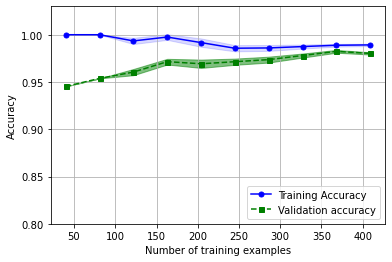

In [47]:
plt.plot(train_sizes, train_mean,
        color='blue', marker='o',
        markersize=5, label='Training Accuracy')

plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='Validation accuracy')

plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.5, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show()

# Addressing over- and underfitting with validation curves

In [48]:
from sklearn.model_selection import validation_curve

In [49]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

In [50]:
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                            X=X_train,
                                            y=y_train,
                                            param_name='logisticregression__C',
                                            param_range=param_range,
                                            cv=10)

In [53]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

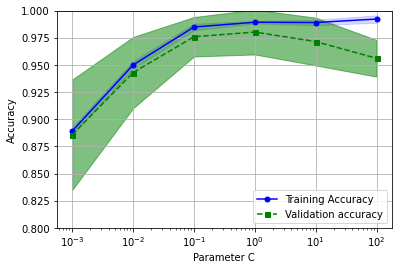

In [54]:
plt.plot(param_range, train_mean,
        color='blue', marker='o',
        markersize=5, label='Training Accuracy')

plt.fill_between(param_range,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='blue')

plt.plot(param_range, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='Validation accuracy')

plt.fill_between(param_range,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.5, color='green')

plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

# Grid Search

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [57]:
pipe_svc = make_pipeline(StandardScaler(),
                        SVC(random_state=1))

In [58]:
param_range = [0.0001, 0.001, 0.01, 0.1,
              1.0, 10.0, 100.0, 1000.0]

In [59]:
param_grid = [{'svc__C': param_range,
              'svc__kernel':['linear']},
             {'svc__C': param_range,
             'svc__gamma': param_range,
             'svc__kernel': ['rbf']}]

In [60]:
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 refit=True,
                 n_jobs=-1)

In [61]:
gs = gs.fit(X_train, y_train)

In [62]:
print(gs.best_score_)

0.9846859903381642


In [63]:
print(gs.best_params_)

{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [65]:
clf = gs.best_estimator_

In [66]:
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100.0, gamma=0.001, random_state=1))])

In [67]:
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.974


# Nested cross validation

In [68]:
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=2)

In [69]:
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

In [70]:
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

CV accuracy: 0.974 +/- 0.015


In [71]:
from sklearn.tree import DecisionTreeClassifier

In [72]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                 param_grid=[{'max_depth': [1,2,3,4,5,6,7,None]}],
                 scoring='accuracy',
                 cv=2)

In [73]:
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

In [74]:
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

CV accuracy: 0.934 +/- 0.016


# Confusion Matrix

In [76]:
from sklearn.metrics import confusion_matrix

In [77]:
pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=1))])

In [78]:
y_pred = pipe_svc.predict(X_test)

In [79]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

In [80]:
print(confmat)

[[71  1]
 [ 2 40]]


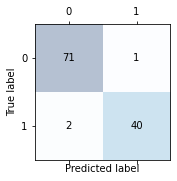

In [81]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, 
                s=confmat[i, j], 
                va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Metrics

In [82]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

In [83]:
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976


In [84]:
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))

Recall: 0.952


In [85]:
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

F1: 0.964


In [86]:
from sklearn.metrics import make_scorer, f1_score

In [87]:
c_gamma_range = [0.01, 0.1, 1.0, 10.0]

In [88]:
param_grid = [{'svc__C': c_gamma_range,
              'svc__kernel': ['linear']},
             {'svc__C' : c_gamma_range,
             'svc__gamma' : c_gamma_range,
             'svc__kernel' : ['rbf']}]

In [89]:
scorer = make_scorer(f1_score, pos_label=0)

In [90]:
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring=scorer,
                 cv=10)

In [91]:
gs = gs.fit(X_train, y_train)

In [93]:
print(gs.best_score_)

0.9861994953378878


In [94]:
print(gs.best_params_)

{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


# Receiver operating characteristic (ROC) area under the curve

In [97]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

In [99]:
pipe_lr = make_pipeline(StandardScaler(),
                       PCA(n_components=2),
                       LogisticRegression(penalty='l2',
                                         random_state=1,
                                         solver='lbfgs',
                                         C=100.0))

In [100]:
X_train2 = X_train[:, [4, 14]]

In [104]:
cv = list(StratifiedKFold(n_splits=3, random_state=1, shuffle=True).split(X_train, y_train))

In [105]:
fig = plt.figure(figsize=(7, 5))

<Figure size 504x360 with 0 Axes>

In [106]:
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

<ipython-input-112-54e306196ab5>:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
<ipython-input-112-54e306196ab5>:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
<ipython-input-112-54e306196ab5>:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


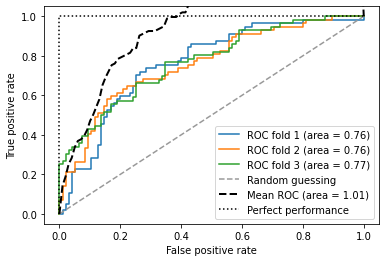

In [112]:
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(
        X_train2[train],
        y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                    probas[:, 1],
                                    pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
            tpr,
            label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1],
        [0, 1],
        linestyle='--',
        color=(0.6, 0.6, 0.6),
        label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1],
        [0, 1, 1],
        linestyle=':',
        color='black',
        label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()

# Micro/Marco for multiclass OvR/OvA

In [113]:
pre_scorer = make_scorer(score_func=precision_score,
                        pos_label=1,
                        greater_is_better=True,
                        average='micro')

# Class imbalance

In [116]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

In [117]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [114]:
from sklearn.utils import resample

In [118]:
print('Number of class 1 examples before:', X_imb[y_imb == 1].shape[0])

Number of class 1 examples before: 40


In [120]:
X_upsampled, y_upsampled = resample(
    X_imb[y_imb == 1],
    y_imb[y_imb == 1],
    replace=True,
    n_samples=X_imb[y_imb == 0].shape[0],
    random_state=123
)

In [121]:
print('Number of class 1 examples after: ', X_upsampled.shape[0])

Number of class 1 examples after:  357


In [124]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [125]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0